In [1]:
import os
from gala import evaluate as ev, imio, viz, morpho, agglo, classify, features
from skimage.util import regular_seeds
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
os.chdir("/home/johnnyt/Documents/research_project_files/")
raw, gt = imio.read_cremi("Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])
bpm = imio.read_h5_stack('raw_slice_1_Probabilities.h5', group='bpm_raw_b')
membrane_prob = bpm[..., 2]
train_slice = (slice(0, 15), slice(0, 480), slice(0, 480))
test_slice = (slice(0, 15), slice(480, 960), slice(480, 960))
gt_larger_2 = gt[train_slice]
raw_larger_2 = 1-raw[train_slice]/255
raw_test_slice = raw[test_slice]
ws_larger_seeds_2 = regular_seeds(raw_larger_2[0].shape, n_points=700)
ws_larger_seeds_2 = np.broadcast_to(ws_larger_seeds_2, raw_larger_2.shape)
ws_larger_water = morpho.watershed_sequence(membrane_prob[train_slice], ws_larger_seeds_2, n_jobs=-1)
raw_larger_testing_2 = membrane_prob[test_slice]
gt_larger_testing_2 = gt[test_slice]
gg = np.argsort(np.bincount(gt_larger_2.astype(int).ravel()))[-10:]
sparse_large = imio.extract_segments(gt_larger_2, ids = gg)
ws_larger_testing_2 = morpho.watershed_sequence(raw_larger_testing_2, ws_larger_seeds_2, n_jobs=-1)
fm = features.moments.Manager()
fh = features.histogram.Manager()

In [3]:
fc = features.base.Composite(children=[fm, fh])
g_train_larger_2 = agglo.Rag(ws_larger_water, bpm[train_slice], feature_manager=fc)
(X2, y2, w2, merges2) = g_train_larger_2.learn_agglomerate(gt_larger_2, fc, classifier='logistic')[0]
y2 = y2[:, 0]

In [15]:
rf_log_large_2 = classify.get_classifier('logistic').fit(X2,y2)
learned_policy_large_2 = agglo.classifier_probability(fc, rf_log_large_2)
g_test_large_2 = agglo.Rag(ws_larger_testing_2, bpm[test_slice], feature_manager=fc, merge_priority_function=learned_policy_large_2)
g_test_large_2.agglomerate(np.inf)
seg_stack_large_2 = [g_test_large_2.get_segmentation(t) for t in np.arange(0,1, 0.01)]
split_vi_score_large_2 = [ev.split_vi(seg_stack_large_2[t], gt_larger_testing_2) for t in range(len(seg_stack_large_2))]
split_vi_array_2 = np.array(split_vi_score_large_2)
best_seg_ind = np.argmin(split_vi_array_2.sum(axis=1))
best_seg = seg_stack_large_2[best_seg_ind]
imio.write_h5_stack(npy_vol=split_vi_array_2, compression='lzf', fn='stack_of_segs_20_10.h5')

100%|██████████| 10934/10934 [00:52<00:00, 208.38it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?i

OSError: Unable to create file (Unable to open file: name = 'stack_of_segs_20_10.h5', errno = 17, error message = 'file exists', flags = 15, o_flags = c2)

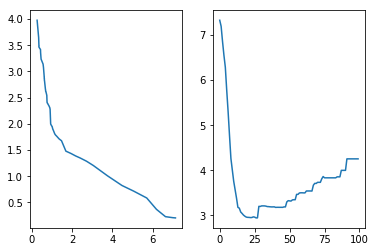

In [76]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.plot(split_vi_array_2[:, 1], split_vi_array_2[:, 0])
target_segs = np.argsort(np.bincount(seg_stack_large_2[9].astype(int).ravel()))[-10:]
ax0.set_title("Split VI")
ax1.set_title("Cumulative VI")
ax1.plot(split_vi_array_2.sum(axis=1))

In [63]:
split_idxs, split_errs, merge_idxs, merge_errs = ev.sorted_vi_components(best_seg, gt_larger_testing_2)
split_idxs_sorted, merge_idxs_sorted = np.argsort(split_idxs), np.argsort(merge_idxs)
split_err_unsorted, merge_err_unsorted = split_errs[split_idxs_sorted], merge_errs[merge_idxs_sorted]
split_err_img, merge_err_img = split_err_unsorted[gt_larger_testing_2], merge_err_unsorted[best_seg]

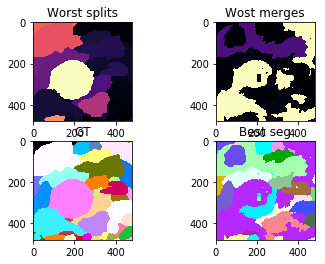

In [74]:
fig, ax = plt.subplots(ncols=2, nrows=2)
ax[0,0].set_title("Worst splits")
ax[0,1].set_title("Wost merges")
ax[1,0].set_title("GT")
ax[1,1].set_title("Best seg")
viz.imshow_magma(split_err_img[12, ...], axis= ax[0,0])
viz.imshow_magma(merge_err_img[12, ...], axis= ax[0,1])
viz.imshow_rand(gt[test_slice][12, ...], axis=ax[1,0])
viz.imshow_rand(best_seg[12, ...], axis=ax[1,1])

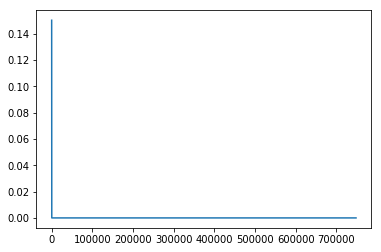

In [35]:
plt.plot(err1)

In [115]:
cont_table = ev.contingency_table(best_seg, gt[test_slice])

In [124]:
worst_merge_comps = ev.split_components(merge_idxs[0], num_elems=10, cont=cont_table.T, axis=0)

In [129]:
1812 in (best_seg.ravel())

False

In [126]:
worst_merge_array = np.array(worst_merge_comps[0:3], dtype=np.int64)
worst_merge_array[:, 0]

array([20269, 20231, 20252])

In [73]:
np.cumsum(np.array(worst_merge_comps)[:, 1])

array([ 0.55431566,  0.82363144,  0.95866726,  0.96692098,  0.9700659 ,
        0.97283627,  0.97548853,  0.97807667,  0.98063782,  0.98300664])

In [131]:
extracted_worst_merge_comps = imio.extract_segments(ids=worst_merge_array[:, 0], seg=best_seg)

In [102]:
abc = raw[test_slice]

In [133]:
imio.write_vtk(extracted_worst_merge_comps, fn='worst_merge_comps_20_10.vtk',spacing=[4, 4, 40])

In [134]:
imio.write_vtk(abc, fn='raw_test_slice_20_10.vtk',spacing=[4, 4, 40])

In [77]:
pwd

'/home/johnnyt/Documents/research_project_files'